In [426]:
from collections import namedtuple
import random
from copy import deepcopy
from itertools import accumulate
from operator import xor
import matplotlib.pyplot as plt

## The *Nim* and *Nimply* classes

In [427]:
Nimply = namedtuple("Nimply", "row, num_objects")

In [428]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self):
        return sum(self._rows) > 0

    def __str__(self):
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple:
        return tuple(self._rows)

    def nimming(self, ply: Nimply) -> None:
        row, num_objects = ply
        assert self._rows[row] >= num_objects
        self._rows[row] -= num_objects   
    
    def adding(self, ply: Nimply) -> None:
        row, num_objects = ply
        self._rows[row] += num_objects

In [429]:
def nim_sum(state: Nim) -> int:
    *_, result = accumulate(state.rows, xor)
    return result


def cook_status(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_moves"] = [
        (r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)
    ]
    cooked["active_rows_number"] = sum(o > 0 for o in state.rows)
    cooked["shortest_row"] = min((x for x in enumerate(state.rows) if x[1] > 0), key=lambda y: y[1])[0]
    cooked["longest_row"] = max((x for x in enumerate(state.rows)), key=lambda y: y[1])[0]
    cooked["nim_sum"] = nim_sum(state)

    brute_force = list()
    for m in cooked["possible_moves"]:
        tmp = deepcopy(state)
        tmp.nimming(m)
        brute_force.append((m, nim_sum(tmp)))
    cooked["brute_force"] = brute_force

    return cooked

# for the recursive function, to save a bit the computational cost, because compute only the possible moves 
# removing only one object (instead of use "cook_status(state: Nim) -> dict:")
def cook_status_for_rec(state: Nim) -> dict:
    cooked = dict()
    cooked["possible_remove_one"]= [
        (r, 1) for r, c  in enumerate(state.rows) if c > 0
    ]
    return cooked


In [430]:
NIM_SIZE= 5

### Find all possible states from a state

In [431]:
def all_possible_states(res: set, state: Nim):
    recursive_search(state, res)
    #adding the tuple (0,0,0,0,0) (eg if NIM_SIZE=5)
    all_zero= []   
    for _ in range(NIM_SIZE):
        all_zero.append(0)
    res.add(tuple(all_zero))
    return res #this set contains all the possible states, for instance, for NIM_SIZE=5, from (1,3,5,7,9) to (0,0,0,0,0)

def recursive_search(state: Nim, result: set):
    if state.rows  not in result: #enter only if the state is not already in the set
        data= cook_status_for_rec(state)
        result.add(state.rows)
        for p in data["possible_remove_one"]:
            state.nimming(p)
            if(state): #if it is not all zeros, do the recursive call
                recursive_search(state, result)
            if list(data["possible_remove_one"]) != []: #if not all the considered plys from the current state are done
                #add again the object removed by the ply to the state and remove the ply from the possible moves
                state.adding(p)
                temp= list(data["possible_remove_one"])
                temp.remove(p)
                data["possible_remove_one"]= temp



### Random Agent

In [432]:
def pure_random(state: Nim) -> Nimply:
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)

### Optimal (Nim-Sum) Agent

In [433]:
def optimal_strategy(state: Nim) -> Nimply:
    data = cook_status(state)
    return next((bf for bf in data["brute_force"] if bf[1] == 0), random.choice(data["brute_force"]))[0]

### Some hard-coded strategies

In [434]:
def my_smart(state: Nim) -> Nimply:
    """Do actions to try to win the majority of the times"""
    data= cook_status(state)
    if(data["active_rows_number"]>=3):
        return Nimply(data["shortest_row"], 1)
    elif(data["active_rows_number"]==2 and state.rows[data["longest_row"]]>1):
        return Nimply(data["longest_row"], state.rows[data["longest_row"]]-1)
    elif(data["active_rows_number"]==2 and state.rows[data["longest_row"]]<=1):
        return Nimply(data["longest_row"], 1)
    elif(data["active_rows_number"]==1):
        return Nimply(data["shortest_row"], state.rows[data["shortest_row"]])


In [435]:
def giovanni(state: Nim) -> Nimply:
    data= cook_status(state)
    """If active rows are even, take 1 from the longest; else take all from the shortest"""
    if(data["active_rows_number"] % 2 ==0):
        return Nimply(data["longest_row"], 1)
    else:
        return Nimply(data["shortest_row"], state.rows[data["shortest_row"]])

## Reinforcement Learning Agent

In [436]:
class Agent(object):
    def __init__(self, states, alpha=0.15, random_factor=0.2):  # 80% explore, 20% exploit
        self.state_history = []  # state, reward
        self.alpha = alpha
        self.random_factor = random_factor
        self.G = {}
        self.init_reward(states)

    def init_reward(self, states):
        for st in states:
            self.G[st] = random.uniform(-1, 1) #randomic initialization

    def choose_action(self, state:Nim):
        allowedMoves= [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
        maxG = -10e15
        next_move = None
        if random.random() < self.random_factor:
            # if random number below random factor, choose random action
            next_move = random.choice(allowedMoves)
        else:
            # if exploiting, gather all possible actions and choose one with the highest G (reward)
            for action in allowedMoves:
                state.nimming(action) # do a nim
                if self.G[state.rows] >= maxG: # verify if the G is better than the best so far
                    next_move = action
                    maxG = self.G[state.rows] 
                state.adding(action)  # add again the objects removed from the nimming
        return next_move #return the ply

    def get_reward(self, p1_won= None):
        if p1_won != None: 
            if p1_won:
                return 10 # if the agent won
            else:
                return -10 # if the agent lost       
        else:
            return -1 # if it is not the end of the match

    def update_state_history(self, state, reward):
        self.state_history.append((state, reward))

    def learn(self):
        target = 0
        for prev, reward in reversed(self.state_history):
            self.G[prev] = self.G[prev] + self.alpha * (target - self.G[prev])
            target += reward
        self.state_history = []
        self.random_factor -= 10e-5  # decrease random factor each episode of play


### "Main"

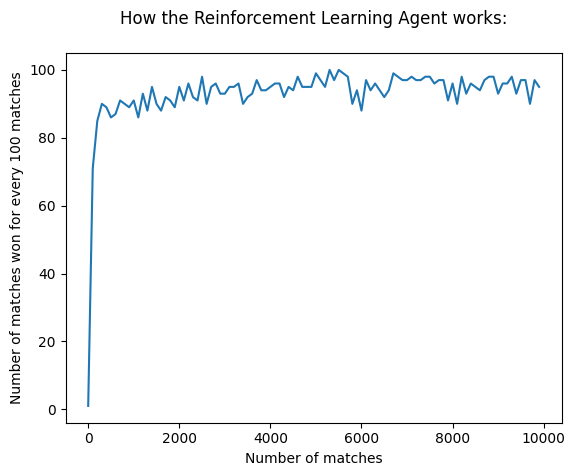

[1, 71, 85, 90, 89, 86, 87, 91, 90, 89, 91, 86, 93, 88, 95, 90, 88, 92, 91, 89, 95, 91, 96, 92, 91, 98, 90, 95, 96, 93, 93, 95, 95, 96, 90, 92, 93, 97, 94, 94, 95, 96, 96, 92, 95, 94, 98, 95, 95, 95, 99, 97, 95, 100, 97, 100, 99, 98, 90, 94, 88, 97, 94, 96, 94, 92, 94, 99, 98, 97, 97, 98, 97, 97, 98, 98, 96, 97, 97, 91, 96, 90, 98, 93, 96, 95, 94, 97, 98, 98, 93, 96, 96, 98, 93, 97, 97, 90, 97, 95]


In [437]:
res= set() 
robot = Agent(all_possible_states(res, Nim(NIM_SIZE)))
winsHistory = []
indices = []
p1_wins=0
all_zero= []   
for _ in range(NIM_SIZE):
    all_zero.append(0)
all_zero= tuple(all_zero)

for m in range(10000):
    x= Nim(NIM_SIZE)
    if m%2== 0: #one time it starts first, one time second
        p1_turn= True
    else:
        p1_turn= False
    while(x):
        if(p1_turn):
            ply = robot.choose_action(x)
            x.nimming(ply)
            if x.rows!= all_zero: # if it is not in the final state
                reward= robot.get_reward()
                robot.update_state_history(x.rows, reward)           
            p1_turn= False
        else:
            #ply= optimal_strategy(x)
            #ply= giovanni(x)
            #ply= my_smart(x)
            ply= pure_random(x)
            x.nimming(ply)
            p1_turn= True
    reward= robot.get_reward(not p1_turn) 
    robot.update_state_history(x.rows, reward)   
    robot.learn() #it learns after each match
    #code for the plot:
    if(not p1_turn): #p1 won
        p1_wins+=1
    if m % 100 == 0: 
        winsHistory.append(p1_wins)
        indices.append(m)
        p1_wins=0  
       
plt.plot(indices, winsHistory)
plt.xlabel('Number of matches')
plt.ylabel('Number of matches won for every 100 matches')
plt.title('How the Reinforcement Learning Agent works:\n')
plt.show()
print(winsHistory)
    